<a href="https://colab.research.google.com/github/sapperka/CCCL/blob/main/PZ2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Выполнение практической работы №2 по предмету Система для сбора событий и логов на тему - "Анализ логов"

Выполнил студент группы: ББМО-02-23 Рыбаков Владислав

Номер варианта соответствует значению - №пп % 16 + 1

27 % 16 + 1 = 12

В качестве логов по варианту выбираем: Proxifier


## Начнем с загрузки репозитория в рабочую область проекта:

In [6]:
import os.path

if not os.path.isdir("./loghub/"):
    !git clone https://github.com/logpai/loghub

## Создание базы данных для хранения записей логов Proxifier

In [8]:
import sqlite3

if not os.path.isdir("./db/"):
    os.makedirs("./db/")

# Путь к файлу, хранящему БД:
db_path = './db/log-Proxifier-analysis.db'

# Использование контекстного менеджера для работы с базой данных
with sqlite3.connect(db_path, timeout=10) as connection:
    cursor = connection.cursor()

    # Очистка таблицы
    cursor.execute("DELETE FROM logs")

    # Парсинг файла с логом
    with open('./loghub/Mac/Mac_2k.log', 'r', encoding='utf-8') as log_file:
        for line in log_file:
            logs_normalized = line.split(" ")
            datetime = "2023 " + " ".join(logs_normalized[0:4])
            user = logs_normalized[4]
            component = logs_normalized[5]
            content = " ".join(logs_normalized[6:]).replace("\n", "")

            # Вставка данных в таблицу
            query = f'INSERT INTO logs (Datetime, User, Component, Content) VALUES ("{datetime}", "{user}", "{component}", "{content}")'
            try:
                cursor.execute(query)
            except Exception as e:
                print(f"Ошибка при вставке данных: {e}")
                print(query)

    # Сохранение изменений
    connection.commit()

Ошибка при вставке данных: near "authorMacBook": syntax error
INSERT INTO logs (Datetime, User, Component, Content) VALUES ("2023 Jul  1 09:19:03", "authorMacBook-Pro", "configd[53]:", "setting hostname to "authorMacBook-Pro.local"")
Ошибка при вставке данных: near "Account": syntax error
INSERT INTO logs (Datetime, User, Component, Content) VALUES ("2023 Jul  1 10:13:39", "calvisitor-10-105-160-95", "secd[276]:", " SOSAccountThisDeviceCanSyncWithCircle sync with device failure: Error Domain=com.apple.security.sos.error Code=1035 "Account identity not set" UserInfo={NSDescription=Account identity not set}")
Ошибка при вставке данных: near "query": syntax error
INSERT INTO logs (Datetime, User, Component, Content) VALUES ("2023 Jul  1 11:24:45", "calvisitor-10-105-160-95", "secd[276]:", " securityd_xpc_dictionary_handler cloudd[326] copy_matching Error Domain=NSOSStatusErrorDomain Code=-50 "query missing class name" (paramErr: error in user parameter list) UserInfo={NSDescription=query 

## Парсинг логов Proxifier и сохранение записей в БД

In [9]:
# Подключение к БД и создание курсора:
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# Очистка таблицы во избежание дублирования данных:
cursor.execute("DELETE FROM logs")

# Парсинг файла с логом:
with open('./loghub/Proxifier/Proxifier_2k.log', 'r', encoding='utf-8') as log_file:
    for line in log_file:
        # Пример парсинга строки:
        parts = line.strip().split("] ")
        datetime = parts[0].replace("[", "")
        user_component_content = parts[1].split(" ", 2)
        user = user_component_content[0]
        component = user_component_content[1].replace(":", "")
        content = user_component_content[2]

        # Вставка данных в таблицу:
        query = f'INSERT INTO logs (Datetime, User, Component, Content) VALUES ("{datetime}", "{user}", "{component}", "{content}")'
        try:
            cursor.execute(query)
        except Exception as e:
            print(f"Ошибка при вставке данных: {e}")
            print(query)

connection.commit()
cursor.close()
connection.close()

## Просмотр полученной БД с данными

In [10]:
import pandas as pd

# Подключение к БД и создание курсора:
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# Выборка всех записей из таблицы:
cursor.execute("SELECT * FROM logs")
rows = cursor.fetchall()

cursor.close()
connection.close()

# Запись данных в объект DataFrame:
log_df = pd.DataFrame(rows, columns=("Id", "Datetime", "User", "Component", "Content"))
log_df

,Id,Datetime,User,Component,Content
0,1938,10.30 16:49:06,chrome.exe,-,proxy.cse.cuhk.edu.hk:5070 open through proxy ...
1,1939,10.30 16:49:06,chrome.exe,-,proxy.cse.cuhk.edu.hk:5070 open through proxy ...
2,1940,10.30 16:49:06,chrome.exe,-,proxy.cse.cuhk.edu.hk:5070 open through proxy ...
3,1941,10.30 16:49:07,chrome.exe,-,"proxy.cse.cuhk.edu.hk:5070 close, 0 bytes sent..."
4,1942,10.30 16:49:07,chrome.exe,-,proxy.cse.cuhk.edu.hk:5070 open through proxy ...
...,...,...,...,...,...
1995,3933,07.27 10:23:30,chrome.exe,*64,"- cpro.baidustatic.com:443 close, 334 bytes se..."
1996,3934,07.27 10:23:30,chrome.exe,*64,- q1.cnzz.com:80 open through proxy proxy.cse....
1997,3935,07.27 10:23:42,chrome.exe,*64,"- t12.baidu.com:80 close, 0 bytes sent, 0 byte..."
1998,3936,07.27 10:23:42,chrome.exe,*64,"- mhfm9.us.cdndm5.com:80 close, 0 bytes sent, ..."


## Нормализация данных
### Нормализация столбца Datetime

In [14]:
import sqlite3
import pandas as pd
from datetime import datetime

# Подключение к базе данных:
conn = sqlite3.connect(db_path)

# Загрузка всех данных из таблицы logs:
df = pd.read_sql_query("SELECT * FROM logs", conn)

# Нормализация столбца Datetime:
try:
    df['Datetime'] = pd.to_datetime(df['Datetime'], format='%m.%d %H:%M:%S')
    print("Столбец Datetime успешно нормализован.")
except Exception as e:
    print("Ошибка при нормализации столбца Datetime:", e)

# Закрытие соединения:
conn.close()

# Вывод первых 5 строк для проверки:
print(df.head())

Столбец Datetime успешно нормализован.
     Id            Datetime        User Component  \
0  1938 1900-10-30 16:49:06  chrome.exe         -   
1  1939 1900-10-30 16:49:06  chrome.exe         -   
2  1940 1900-10-30 16:49:06  chrome.exe         -   
3  1941 1900-10-30 16:49:07  chrome.exe         -   
4  1942 1900-10-30 16:49:07  chrome.exe         -   

                                             Content  
0  proxy.cse.cuhk.edu.hk:5070 open through proxy ...  
1  proxy.cse.cuhk.edu.hk:5070 open through proxy ...  
2  proxy.cse.cuhk.edu.hk:5070 open through proxy ...  
3  proxy.cse.cuhk.edu.hk:5070 close, 0 bytes sent...  
4  proxy.cse.cuhk.edu.hk:5070 open through proxy ...  


### Отделение идентификатора компонента от деталей сообщения

In [15]:
import re

# Функция для извлечения компонентов из поля Content:
def parse_content(content):
    match = re.match(r"^(\w+):\s*(.*)$", content)
    if match:
        component = match.group(1)
        message = match.group(2)
        return component, message
    return None, content

# Применение функции ко всем строкам:
parsed_data = df['Content'].apply(parse_content)

# Создание новых столбцов в DataFrame:
df['Parsed_Component'] = parsed_data.apply(lambda x: x[0])
df['Parsed_Message'] = parsed_data.apply(lambda x: x[1])

# Вывод первых 5 строк для проверки:
print(df[['Content', 'Parsed_Component', 'Parsed_Message']].head())

                                             Content Parsed_Component  \
0  proxy.cse.cuhk.edu.hk:5070 open through proxy ...             None   
1  proxy.cse.cuhk.edu.hk:5070 open through proxy ...             None   
2  proxy.cse.cuhk.edu.hk:5070 open through proxy ...             None   
3  proxy.cse.cuhk.edu.hk:5070 close, 0 bytes sent...             None   
4  proxy.cse.cuhk.edu.hk:5070 open through proxy ...             None   

                                      Parsed_Message  
0  proxy.cse.cuhk.edu.hk:5070 open through proxy ...  
1  proxy.cse.cuhk.edu.hk:5070 open through proxy ...  
2  proxy.cse.cuhk.edu.hk:5070 open through proxy ...  
3  proxy.cse.cuhk.edu.hk:5070 close, 0 bytes sent...  
4  proxy.cse.cuhk.edu.hk:5070 open through proxy ...  


### Сохранение нормализованных данных в новую таблицу

In [17]:
import sqlite3
import pandas as pd

# Подключение к базе данных и загрузка данных:
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM logs", conn)

# Нормализация столбца Datetime:
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%m.%d %H:%M:%S')

# Функция для извлечения компонентов из поля Content:
def parse_content(content):
    match = re.match(r"^(\w+):\s*(.*)$", content)
    if match:
        component = match.group(1)
        message = match.group(2)
        return component, message
    return None, content

# Применение функции ко всем строкам:
parsed_data = df['Content'].apply(parse_content)

df['Parsed_Component'] = parsed_data.apply(lambda x: x[0])
df['Parsed_Message'] = parsed_data.apply(lambda x: x[1])

# Сохранение измененного DataFrame в новую таблицу 'logs_parsed':
df.to_sql('logs_parsed', conn, if_exists='replace', index=False)

# Закрытие соединения:
conn.close()

print("Измененные данные успешно сохранены в новую таблицу 'logs_parsed'.")

Измененные данные успешно сохранены в новую таблицу 'logs_parsed'.


### Просмотр полученной таблицы

In [18]:
import pandas as pd

# Подключение к БД и создание курсора:
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# Выборка всех записей из таблицы:
cursor.execute("SELECT * FROM logs_parsed")
rows = cursor.fetchall()

cursor.close()
connection.close()

# Запись данных в объект DataFrame:
log_df_new = pd.DataFrame(rows, columns=("Id", "Datetime", "User", "Component", "Content", "Parsed_Component", "Parsed_Message"))
log_df_new

,Id,Datetime,User,Component,Content,Parsed_Component,Parsed_Message
0,1938,1900-10-30 16:49:06,chrome.exe,-,proxy.cse.cuhk.edu.hk:5070 open through proxy ...,None,proxy.cse.cuhk.edu.hk:5070 open through proxy ...
1,1939,1900-10-30 16:49:06,chrome.exe,-,proxy.cse.cuhk.edu.hk:5070 open through proxy ...,None,proxy.cse.cuhk.edu.hk:5070 open through proxy ...
2,1940,1900-10-30 16:49:06,chrome.exe,-,proxy.cse.cuhk.edu.hk:5070 open through proxy ...,None,proxy.cse.cuhk.edu.hk:5070 open through proxy ...
3,1941,1900-10-30 16:49:07,chrome.exe,-,"proxy.cse.cuhk.edu.hk:5070 close, 0 bytes sent...",None,"proxy.cse.cuhk.edu.hk:5070 close, 0 bytes sent..."
4,1942,1900-10-30 16:49:07,chrome.exe,-,proxy.cse.cuhk.edu.hk:5070 open through proxy ...,None,proxy.cse.cuhk.edu.hk:5070 open through proxy ...
...,...,...,...,...,...,...,...
1995,3933,1900-07-27 10:23:30,chrome.exe,*64,"- cpro.baidustatic.com:443 close, 334 bytes se...",None,"- cpro.baidustatic.com:443 close, 334 bytes se..."
1996,3934,1900-07-27 10:23:30,chrome.exe,*64,- q1.cnzz.com:80 open through proxy proxy.cse....,None,- q1.cnzz.com:80 open through proxy proxy.cse....
1997,3935,1900-07-27 10:23:42,chrome.exe,*64,"- t12.baidu.com:80 close, 0 bytes sent, 0 byte...",None,"- t12.baidu.com:80 close, 0 bytes sent, 0 byte..."
1998,3936,1900-07-27 10:23:42,chrome.exe,*64,"- mhfm9.us.cdndm5.com:80 close, 0 bytes sent, ...",None,"- mhfm9.us.cdndm5.com:80 close, 0 bytes sent, ..."


## Статистический анализ и визуализация

### Анализ по компонентам

In [20]:
print(df['Parsed_Component'].value_counts(dropna=False))

Parsed_Component
None    2000
Name: count, dtype: int64


                                             Content       Parsed_Component  \
0  proxy.cse.cuhk.edu.hk:5070 open through proxy ...  proxy.cse.cuhk.edu.hk   
1  proxy.cse.cuhk.edu.hk:5070 open through proxy ...  proxy.cse.cuhk.edu.hk   
2  proxy.cse.cuhk.edu.hk:5070 open through proxy ...  proxy.cse.cuhk.edu.hk   
3  proxy.cse.cuhk.edu.hk:5070 close, 0 bytes sent...  proxy.cse.cuhk.edu.hk   
4  proxy.cse.cuhk.edu.hk:5070 open through proxy ...  proxy.cse.cuhk.edu.hk   

                                      Parsed_Message  
0  open through proxy proxy.cse.cuhk.edu.hk:5070 ...  
1  open through proxy proxy.cse.cuhk.edu.hk:5070 ...  
2  open through proxy proxy.cse.cuhk.edu.hk:5070 ...  
3  close, 0 bytes sent, 0 bytes received, lifetim...  
4  open through proxy proxy.cse.cuhk.edu.hk:5070 ...  
Топ 10 компонентов по количеству сообщений:
Parsed_Component
proxy.cse.cuhk.edu.hk    905
get.sogou.com             27
client-cf.dropbox.com     25
api.github.com            21
block.dropbox.com 

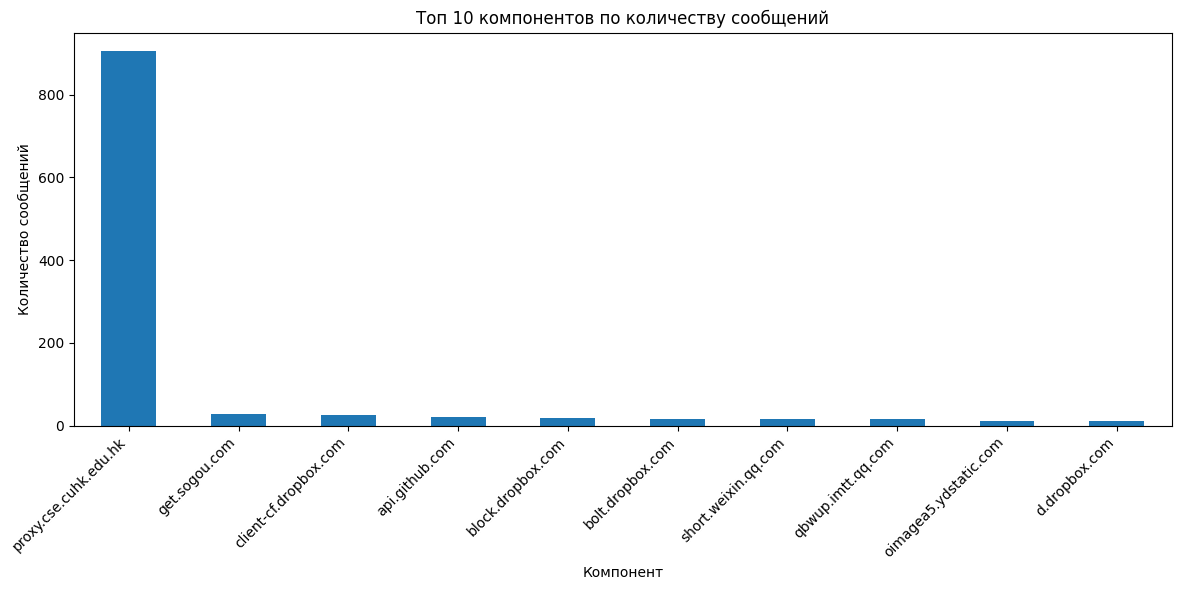

In [21]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# Функция для парсинга
def parse_content(content):
    match = re.match(r"^([\w\.\-]+):\s*(\d+)\s*(.*)$", content)
    if match:
        component = match.group(1)  # "proxy.cse.cuhk.edu.hk"
        message = match.group(3)    # "open through proxy ..."
        return component, message
    return None, content

# Применение функции к данным
parsed_data = df['Content'].apply(parse_content)
df['Parsed_Component'] = parsed_data.apply(lambda x: x[0])
df['Parsed_Message'] = parsed_data.apply(lambda x: x[1])

# Проверка результата
print(df[['Content', 'Parsed_Component', 'Parsed_Message']].head())

# Анализ компонентов
component_counts = df['Parsed_Component'].value_counts()
print("Топ 10 компонентов по количеству сообщений:")
print(component_counts.head(10))

# Визуализация
plt.figure(figsize=(12, 6))
component_counts.head(10).plot(kind='bar')
plt.title('Топ 10 компонентов по количеству сообщений')
plt.xlabel('Компонент')
plt.ylabel('Количество сообщений')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Анализ по времени

Распределение сообщений по часам:
Hour
3      27
4      16
5      50
6      10
7      25
8      17
9      57
10     54
13     97
14    133
15    143
16    300
17    358
18    109
19     55
20    363
21    169
22     17
Name: count, dtype: int64


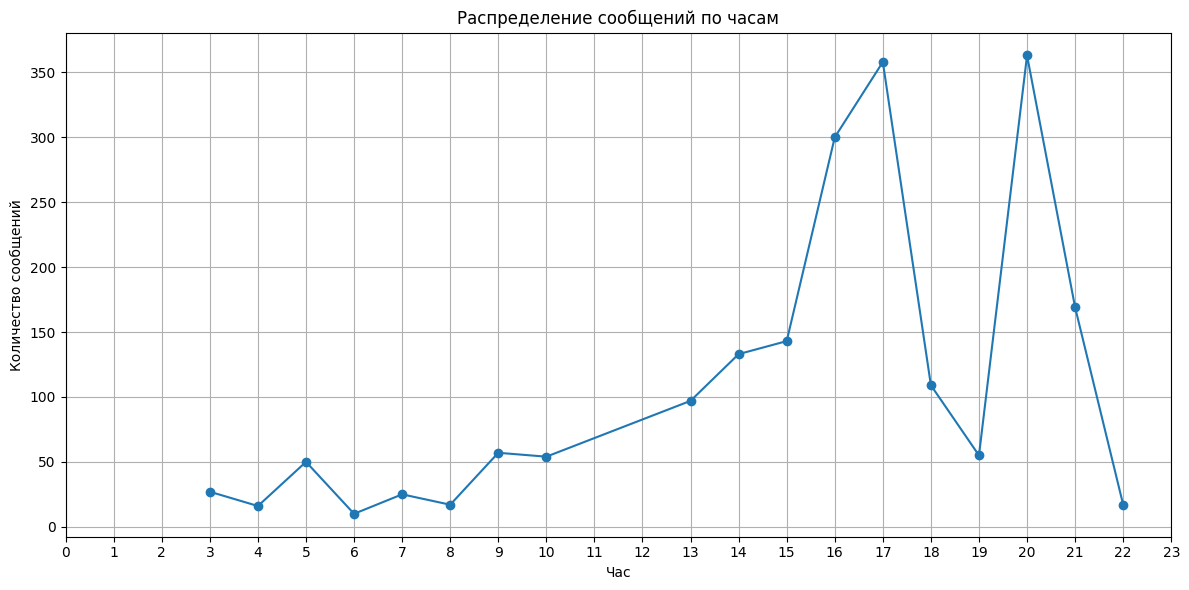

In [22]:
# 2. Анализ по времени:
df['Hour'] = df['Datetime'].dt.hour
hourly_counts = df['Hour'].value_counts().sort_index()
print("Распределение сообщений по часам:")
print(hourly_counts)

# Визуализация распределения по часам:
plt.figure(figsize=(12, 6))
hourly_counts.plot(kind='line', marker='o')
plt.title('Распределение сообщений по часам')
plt.xlabel('Час')
plt.ylabel('Количество сообщений')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.savefig('hourly_distribution.png')
plt.show()
plt.close()

### Анализ по пользователям

Топ 5 пользователей по количеству сообщений:
User
chrome.exe        1529
Dropbox.exe         91
WeChat.exe          69
YodaoDict.exe       61
SogouCloud.exe      38
Name: count, dtype: int64


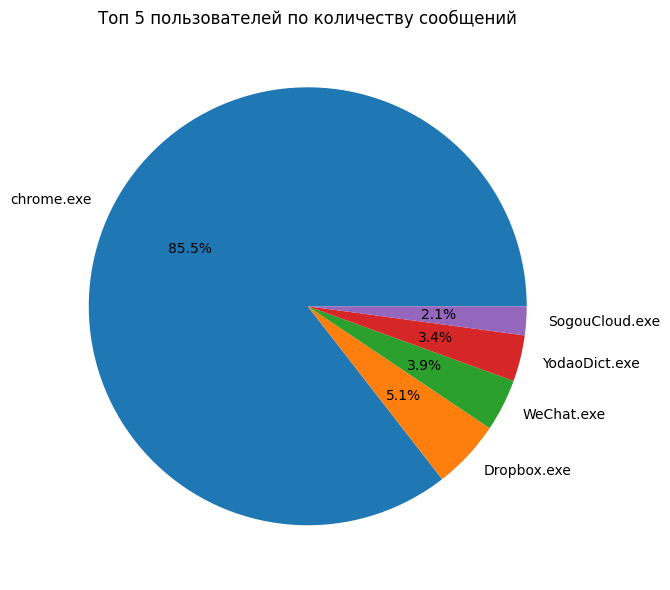

In [23]:
# 3. Анализ по пользователям:
user_counts = df['User'].value_counts()
print("Топ 5 пользователей по количеству сообщений:")
print(user_counts.head())

# Визуализация топ 5 пользователей:
plt.figure(figsize=(10, 6))
user_counts.head().plot(kind='pie', autopct='%1.1f%%')
plt.title('Топ 5 пользователей по количеству сообщений')
plt.ylabel('')
plt.tight_layout()
plt.savefig('top_5_users.png')
plt.show()
plt.close()

### Сохранение графиков и закрытие соединения

In [24]:
print("Графики сохранены в файлы: top_10_components.png, hourly_distribution.png, top_5_users.png")
# Закрытие соединения с базой данных
conn.close()

Графики сохранены в файлы: top_10_components.png, hourly_distribution.png, top_5_users.png
